# Deliverables
Well-documented code for your best-performing pipeline based on the private leaderboard. You may submit your code in one of the following formats:
A single notebook: task_8.ipynb
Multiple notebooks, labeled sequentially: 001_task_8.ipynb, 002_task_8.ipynb …
A single notebook with helper functions in a separate script: task_8.ipynb and task_8_helpers.py
The root segmentation model used in the pipeline. This can be the same model developed in Task 5 or an improved version.

If your pipeline includes other models, such as a shoot segmentation model for better plant localization, you must deliver these as well. For example, if you developed a shoot segmentation model to enhance plant detection, ensure it is included as part of your submission.

Presentation of your pipeline at the final block presentation.

Screenshot of your private leaderboard position and score.
# Client Requirements
The desired sMAPE is less than 10% (Private LB score on the Kaggle competition).
The sMAPE must not exceed 45% (Private LB score on the Kaggle competition).
Your solution must utilize a deep learning model for root segmentation, followed by Root System Architecture (RSA) extraction.
The pipeline should not contain any training code; it should include only preprocessing, inference, and post-processing steps.
Pipeline Input: A directory containing any number of raw images. Pipeline Output: The primary root length for every plant in each image.

To build the comprehensive computer vision pipeline, we'll break down the tasks involved based on the steps required. This pipeline will take as input a directory containing raw images, process them to segment the primary root of plants, and finally output the root length for each plant in every image. I will l integrate the knowledge from Tasks 1–7, specifically the following tasks:

Root segmentation (from Task 5)
Shoot segmentation (optional, for improved plant localization)
Root system architecture (RSA) extraction
Post-processing and inference to calculate primary root length
The pipeline steps we will implement are as follows:

Step 1: Preprocessing
In this step, I prepare the images for efficient inference:

Image normalization (color and intensity normalization).
Resizing/standardizing image sizes to match the input size expected by the deep learning models.
Augmentation (if applicable) for increased model robustness, especially when applying it on the raw images.
Step 2: Model Inference
This part of the pipeline utilizes deep learning models that detect and segment different plant organs:

Root segmentation model – This model will output binary masks for the primary root in each image.
Optional Shoot segmentation model – This model (if utilized) will isolate the shoot system, helping to identify individual plants more clearly.
Step 3: Root Length Calculation
Once we have the segmented root masks, we need to extract the primary root length for each plant:

Calculating pixel count or boundary length from segmented masks.
Mapping pixel count to physical dimensions, provided a scale is given in the dataset (typically, this will be handled by the dataset's metadata).
Step 4: Post-processing
Following the segmentation, post-processing techniques will ensure high-quality segmentation masks:

Morphological operations (e.g., erosion/dilation) to refine root masks and remove noise.
Thinning/connected component analysis to distinguish between different plant structures in complex scenarios.
Step 5: Output Generation
Finally, we output the computed primary root lengths for all plants. This step generates the output in the required Kaggle submission format.



In [ ]:
# Standard libraries
import os
import glob
import shutil
import random

# Numerical and data handling
import numpy as np
import pandas as pd

# Image processing
import cv2
from PIL import Image
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops
from scipy.ndimage import convolve
from scipy.spatial import distance

# Visualization
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, Activation, concatenate,
    Conv2DTranspose, BatchNormalization, Dropout, UpSampling2D
)

# Utilities
from patchify import patchify, unpatchify
import networkx as nx


# Image Preprocessing and Model Prediction Script

## Overview

This script is designed to preprocess images, specifically detecting and cropping regions of interest (e.g., Petri dishes), padding the cropped regions to match a desired patch size, and loading a trained U-Net model for predictions. It includes custom functions for these tasks, as well as for evaluating model performance using the F1 score.

---

## Key Features

### 1. **Petri Dish Detection and Cropping**
The `detect_and_crop` function identifies the largest contour in an image (assumed to be the Petri dish), calculates a square bounding box around it, and extracts the region. It then normalizes the pixel values to float32 for input compatibility with the model.

### 2. **Padding for Consistent Input Size**
The `padder` function ensures that cropped images match the required patch size by adding symmetric padding. This is critical for maintaining compatibility with models that expect inputs of a specific size.

### 3. **Custom F1 Score Function**
The `f1` function calculates the F1 score, which balances precision and recall, making it a reliable metric for evaluating segmentation models. The function includes subfunctions for computing precision and recall individually.

### 4. **Trained U-Net Model Loading**
The script loads a pretrained U-Net model saved in the `.h5` format, which is specialized for segmentation tasks. The model uses the custom F1 score function for evaluation but is not compiled initially to allow for flexible adjustments.

---

## Workflow

1. **Detect and Crop Petri Dish:**
   - Input: Image file path.
   - Output: Cropped, normalized grayscale image along with bounding box details (x, y, side length).

2. **Pad Image:**
   - Input: Cropped grayscale image.
   - Output: Padded image with additional metadata (padding dimensions).

3. **Evaluate Predictions:**
   - The F1 score metric is used for assessing model output against true labels.

4. **Load Model:**
   - The U-Net model is loaded with the required custom F1 metric.

5. **Test Image Processing:**
   - All image files in a specified folder are processed iteratively.

In [2]:
patch_size = 256
example_file_name = f'lucas_230533_unet_model_{patch_size}px.h5'

# Define the function for detecting and cropping the Petri dish from the image
def detect_and_crop(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)[1]
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    side_length = max(w, h)
    center_x, center_y = x + w // 2, y + h // 2
    x = max(center_x - side_length // 2, 0)
    y = max(center_y - side_length // 2, 0)
    x = min(x, image.shape[1] - side_length)
    y = min(y, image.shape[0] - side_length)

    cropped_image = gray[y:y + side_length, x:x + side_length]
    converted_image = (cropped_image / 255).astype(np.float32)
    
    return converted_image, x, y, side_length

# Define the padding function
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding
    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image, top_padding, bottom_padding, left_padding, right_padding

# Define F1 score function
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Load the trained model
patch_size = 512
example_file_name = f'lucas_230533_unet_model_{patch_size}px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1}, compile=False)  # Don't compile initially


# Define the folder containing the test images
test_images_folder = 'input_folder/Kaggle'

# List all image files in the folder (you can modify the file extension if needed)
image_files = glob.glob(os.path.join(test_images_folder, '*.tif'))  # Change extension to match your images

# Image Segmentation and Mask Prediction Pipeline

## Overview

This section of the script processes test images by detecting and cropping regions of interest, padding them, segmenting them into patches, and passing these patches through a U-Net model for mask predictions. The predicted masks are then reassembled and saved as output images.

---

## Key Features

### 1. **Image Processing Pipeline**
The script processes images iteratively from a specified folder:
- **Detection and Cropping:** Identifies the Petri dish region in each image and crops it for further processing.
- **Padding:** Ensures the cropped images match the desired patch size for consistent patchification.

### 2. **Patch-Based Prediction**
- **Patchify:** Splits padded images into smaller patches of a fixed size (`512x512`).
- **Model Prediction:** Passes each patch through the trained U-Net model for mask prediction.
- **Unpatchify:** Reassembles the patches into a full-size predicted mask corresponding to the original image dimensions.

### 3. **Mask Output**
- **Grayscale Mask:** Saves the predicted mask for each image as a `.png` file in the `output_folder`, scaling the mask to `[0, 255]` for proper visualization and storage.

In [3]:
for image_path in image_files:
    # Process each image
    petri_dish, x, y, side_length = detect_and_crop(image_path)
    
    # Pad the cropped Petri dish image
    petri_dish_padded, top_padding, bottom_padding, left_padding, right_padding = padder(petri_dish, patch_size)
    
    # Create patches
    patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)
    i = patches.shape[0]
    j = patches.shape[1]

    # Predict on patches
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    predicted_mask = model.predict(patches)

    # Unpatch the predicted mask
    predicted_mask = predicted_mask.reshape(i, j, patch_size, patch_size)
    original_image_size = petri_dish_padded.shape[:2]
    predicted_mask = unpatchify(predicted_mask, original_image_size)

    # Save the predicted mask as PNG
    output_path = os.path.join('output_folder', f'predicted_mask_{os.path.basename(image_path)}')
    os.makedirs('output_folder', exist_ok=True)  # Ensure the output folder exists
    cv2.imwrite(output_path, (predicted_mask * 255).astype(np.uint8))  # Scale to [0, 255] and save as grayscale PNG

2/2 [==============================] - 0s 271ms/step


# Root Skeletonization & Length Tracing

## Overview

This cell processes binary root masks, extracts skeletons, traces the main root path, and records root lengths (in pixels) for multiple plant sections per image.

---

## Key Steps

### 1. **Image Loading**
- Loads and sorts all binary mask images from `output_folder`.
- Output lengths are saved as a CSV file.

### 2. **Node Detection**
- Identifies **endpoints** and **junctions** in the skeleton using convolution.
- These nodes anchor the path tracing process.

### 3. **Skeleton Tracing**
- **Code2:** Finds the shortest valid path (≥50 px) from top to bottom node.
- **Code1:** Fallback that finds the longest upward path without downward turns.

### 4. **Skeleton Preprocessing**
- Applies different thresholds and cleaning:
  - **Code2 uses 13** (basic skeleton).
  - **Code1 uses 5** with morphological closing and keeps only the largest structure.

### 5. **Per-Section Analysis**
- Each image is split into **5 vertical sections**.
- For each, the largest root region is processed and traced.
- Results are visualized and logged with plant IDs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


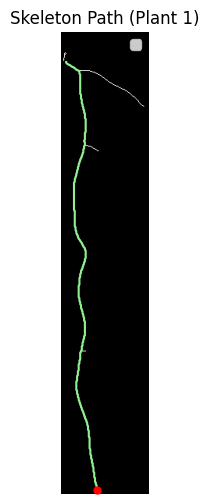

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


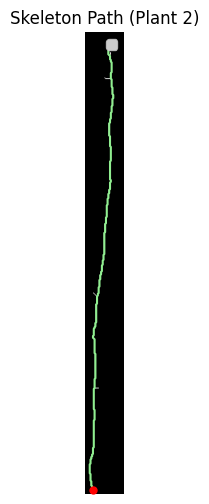

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


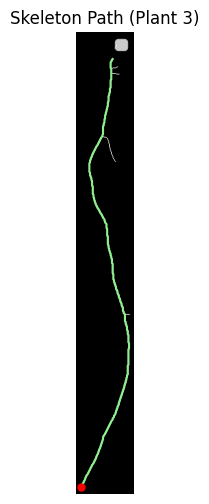

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


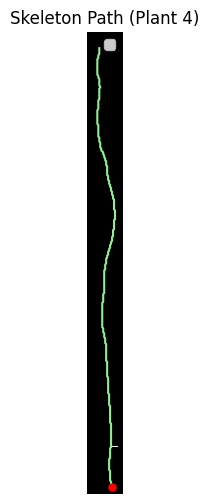

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


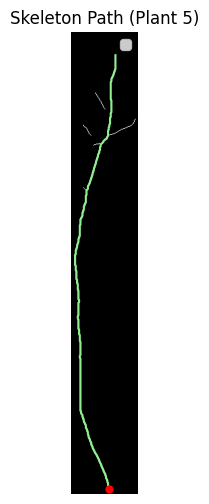

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


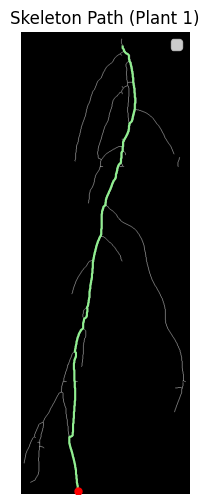

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


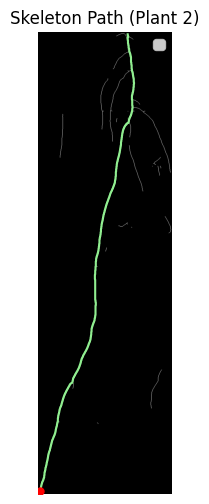

No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


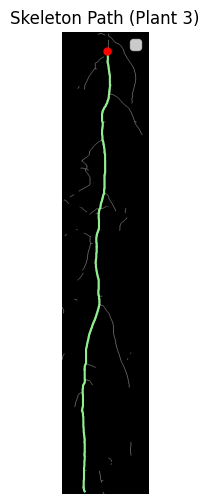

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


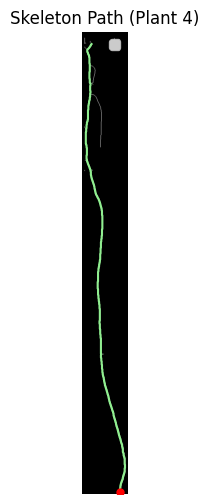

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


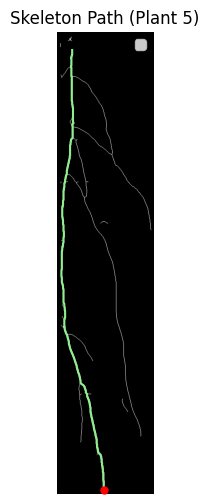

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


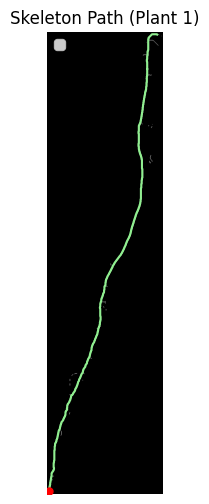

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


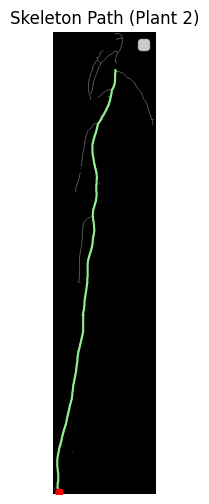

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


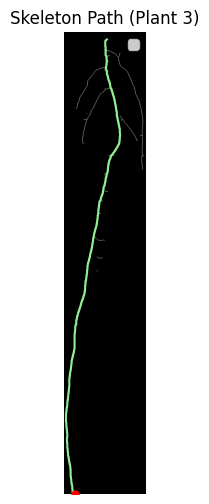

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


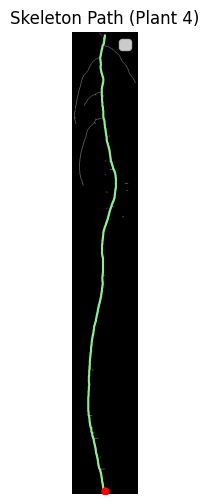

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


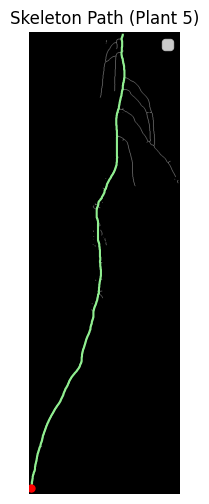

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


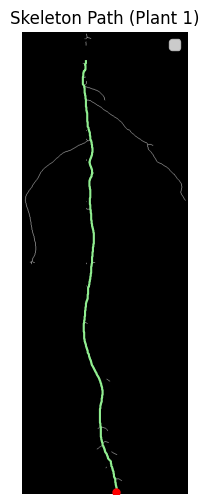

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


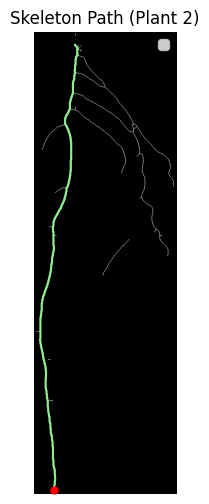

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


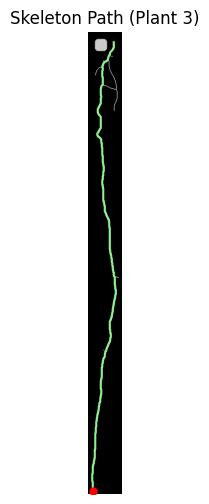

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


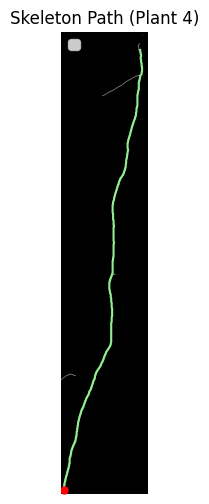

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


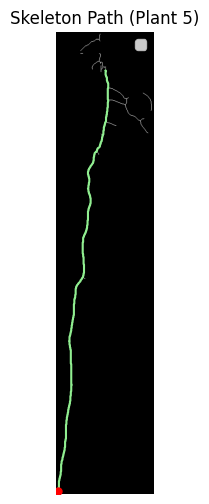

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


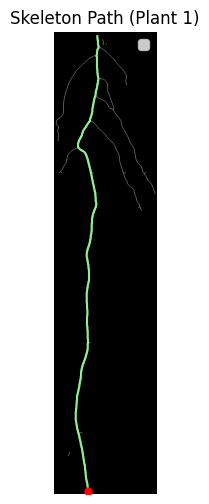

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


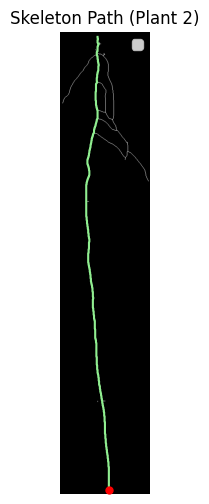

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


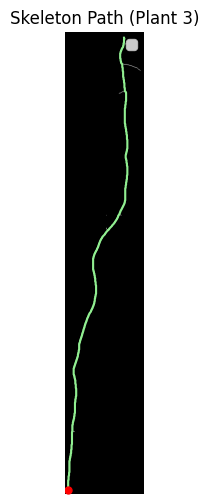

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


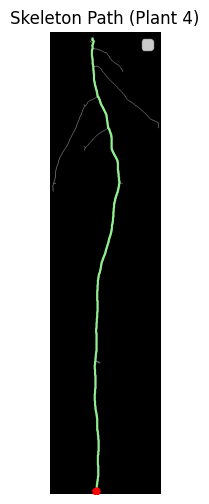

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


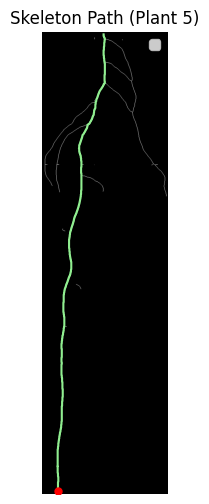

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


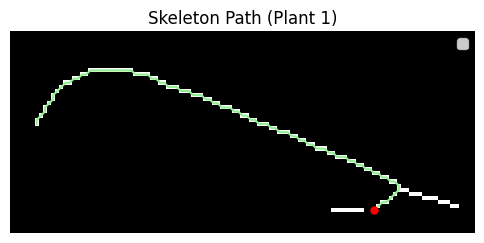

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.
No valid path found.


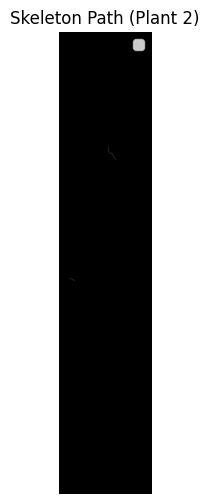

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.
No valid path found.


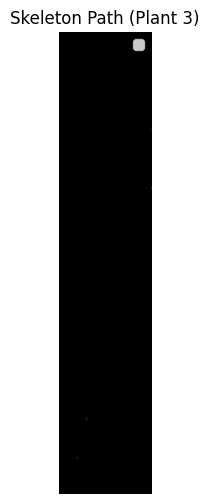

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.


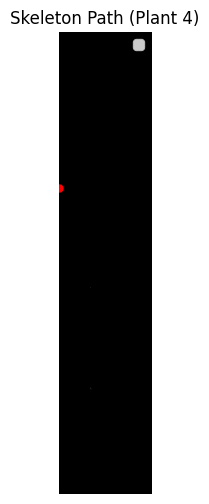

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.


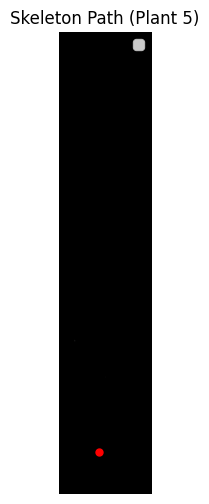

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.
No valid path found.


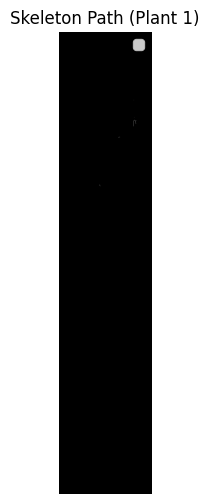

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.


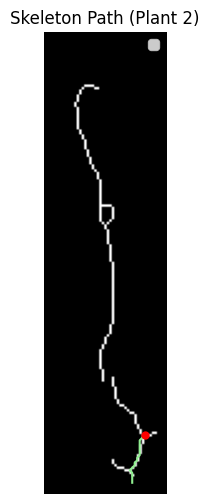

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


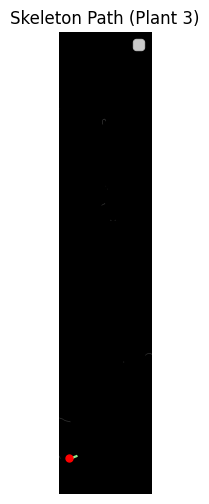

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


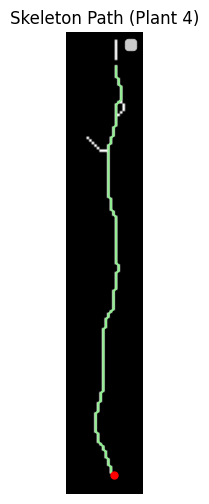

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


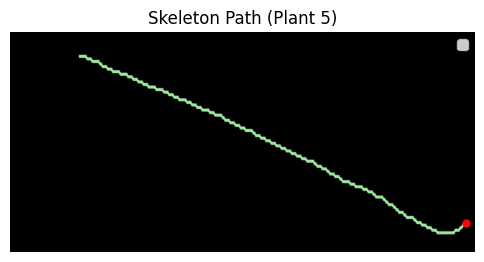

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


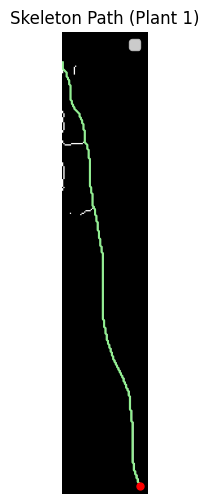

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


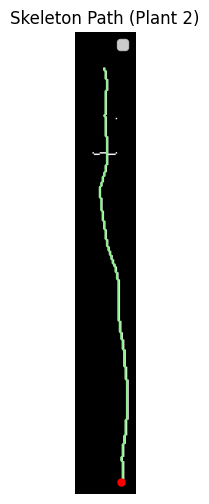

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


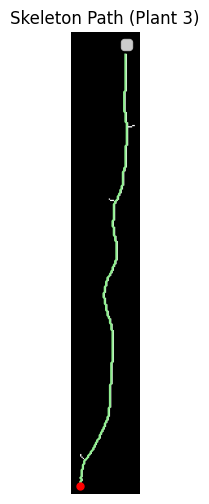

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


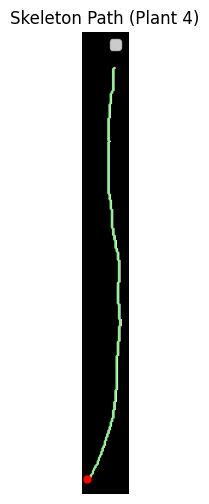

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


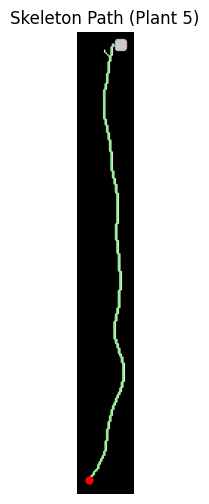

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


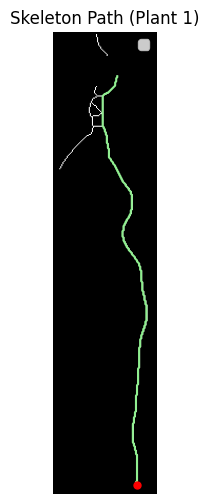

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


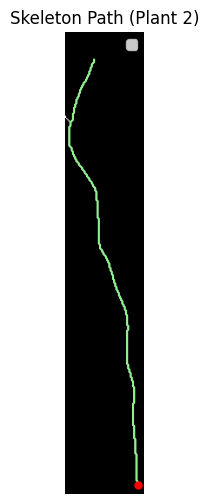

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.
No valid path found.


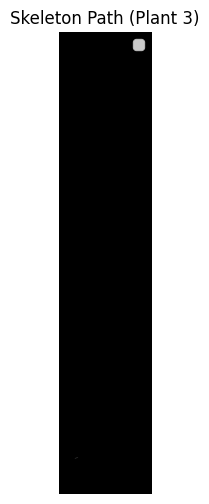

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


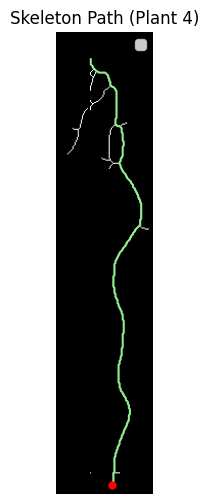

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


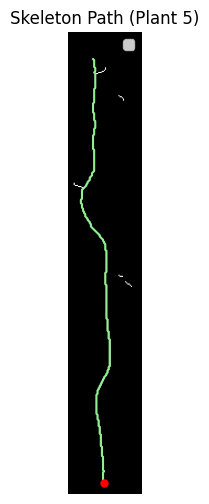

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


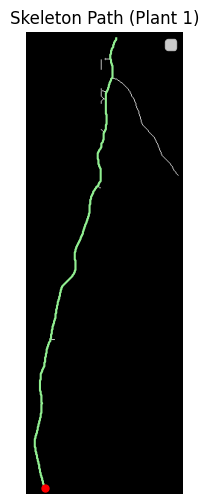

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


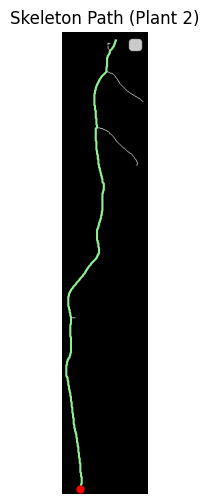

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


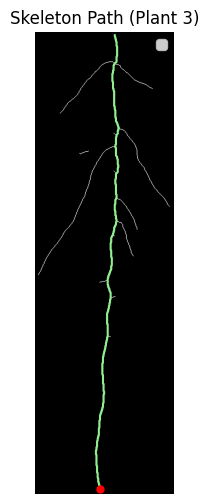

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


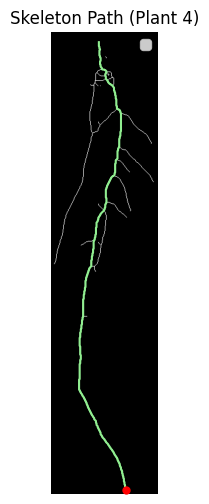

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


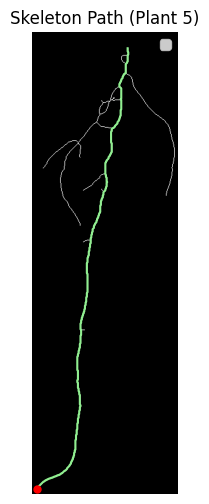

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


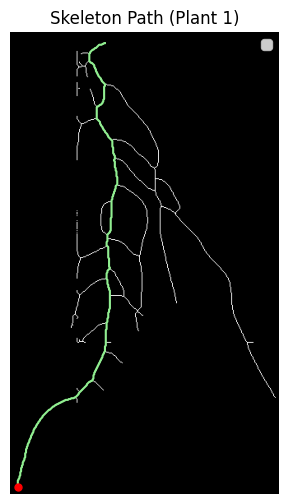

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


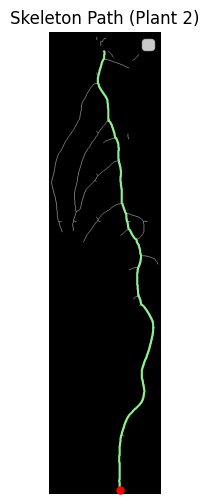

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No valid path found larger than 50px.
No path found, attempting to trace using Code 1's function with threshold 5.
No valid path found.


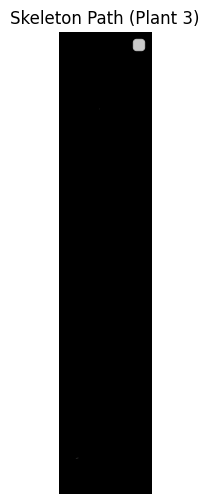

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


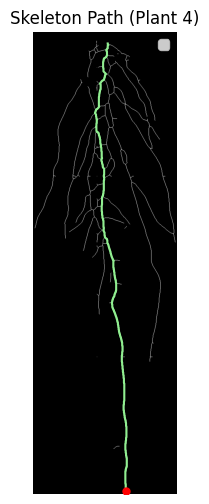

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


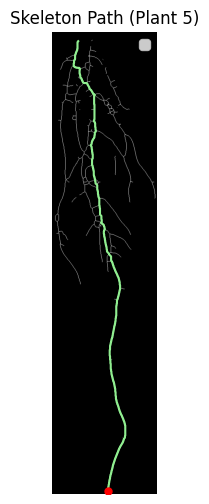

Results saved to root_lengths/root_lengths_combinedT13-T5-1600.csv


In [ ]:
# Define paths
folder_path = 'output_folder'
output_csv_path = 'root_lengths/root_lengths_combinedT13-T5-1600.csv'

# List all image files in the folder
image_files = sorted(
    [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', 'tif'))],
    key=lambda x: int(os.path.splitext(x.replace('predicted_mask_test_image_', '').replace('.png', ''))[0])
)

def detect_nodes(skeleton):
    """Detect endpoints and junctions in a skeletonized image."""
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])
    neighbor_count = convolve(skeleton.astype(np.uint8), kernel, mode='constant', cval=0)
    endpoints = (neighbor_count == 11)
    junctions = (neighbor_count >= 13)
    return endpoints, junctions

def trace_root_path_code2(skeleton):
    """Find and trace the shortest path from the highest to the lowest valid node."""
    endpoints, junctions = detect_nodes(skeleton)
    nodes = np.column_stack(np.where(endpoints | junctions))
    
    if len(nodes) < 2:
        print("Not enough nodes detected for path tracing.")
        return None, 0
    
    nodes = sorted(nodes, key=lambda p: p[0])
    graph = nx.Graph()
    skeleton_points = np.column_stack(np.where(skeleton))
    
    for y, x in skeleton_points:
        neighbors = [(y + dy, x + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1]
                     if (dy, dx) != (0, 0) and (y + dy, x + dx) in map(tuple, skeleton_points)]
        for n in neighbors:
            graph.add_edge((y, x), n, weight=distance.euclidean((y, x), n))
    
    for i in range(len(nodes) - 1):
        highest, lowest = nodes[i], nodes[-1]
        try:
            path = nx.shortest_path(graph, source=tuple(highest), target=tuple(lowest), weight='weight')
            path_length = nx.shortest_path_length(graph, source=tuple(highest), target=tuple(lowest), weight='weight')
            
            if path_length >= 50:
                return path, path_length
        except nx.NetworkXNoPath:
            continue
    
    print("No valid path found larger than 50px.")
    return None, 0

def trace_root_path_code1(skeleton):
    """Find the longest valid path from the lowest to the highest valid node without looping downward."""
    endpoints, junctions = detect_nodes(skeleton)
    nodes = np.column_stack(np.where(endpoints | junctions))

    if len(nodes) < 2:
        print("Not enough nodes detected for path tracing.")
        return None, 0

    # Sort nodes by y-coordinate (ascending) so the lowest is last
    nodes = sorted(nodes, key=lambda p: p[0])

    graph = nx.Graph()
    skeleton_points = np.column_stack(np.where(skeleton))

    for y, x in skeleton_points:
        neighbors = [(y + dy, x + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1]
                     if (dy, dx) != (0, 0) and (y + dy, x + dx) in map(tuple, skeleton_points)]
        for n in neighbors:
            graph.add_edge((y, x), n, weight=distance.euclidean((y, x), n))

    # Start from the lowest node
    start_node = nodes[-1]  

    longest_path = None
    longest_length = 0

    for end_node in nodes:
        if end_node[0] >= start_node[0]:
            continue
        try:
            path = nx.shortest_path(graph, source=tuple(start_node), target=tuple(end_node), weight='weight')
            path_length = nx.shortest_path_length(graph, source=tuple(start_node), target=tuple(end_node), weight='weight')

            # Check if path is valid (does not go downward)
            valid = all(path[i][0] > path[i + 1][0] for i in range(len(path) - 1))

            if valid and path_length > longest_length:
                longest_length = path_length
                longest_path = path

        except nx.NetworkXNoPath:
            continue

    if longest_path is not None:
        return longest_path, longest_length

    print("No valid path found.")
    return None, 0

def process_bounding_box_skeleton(binary_mask, bounding_box, threshold=13):
    """Process the bounding box and skeleton using a specific threshold."""
    x, y, w, h = bounding_box
    box_roi = binary_mask[y:y+h, x:x+w]
    
    # Apply the specified threshold for bounding box processing
    _, box_binary = cv2.threshold(box_roi, threshold, 255, cv2.THRESH_BINARY)
    box_binary = box_binary // 255  # Convert to binary (0 or 1)
    
    # Skeletonization
    skeleton_image = skeletonize(box_binary)
    skeleton_cleaned = remove_small_objects(skeleton_image.astype(bool), min_size=1)
    
    return skeleton_cleaned

def process_bounding_box_skeleton_code1(binary_mask, bounding_box):
    """Process the bounding box for the second try with a lower threshold and morphological closing."""
    x, y, w, h = bounding_box
    box_roi = binary_mask[y:y+h, x:x+w]
    
    # Apply a lower threshold to avoid losing weak parts of the root
    _, box_binary = cv2.threshold(box_roi, 5, 255, cv2.THRESH_BINARY)
    box_binary = box_binary // 255  

    # Morphological closing to remove small gaps in the main root
    kernel = np.ones((3,3), np.uint8)
    box_binary = cv2.morphologyEx(box_binary, cv2.MORPH_CLOSE, kernel)

    # Skeletonization
    skeleton_image = skeletonize(box_binary)

    # Remove small objects (increase min_size to filter out tiny side roots)
    skeleton_cleaned = remove_small_objects(skeleton_image.astype(bool), min_size=1)

    # **Keep only the largest connected component**
    labeled_skeleton = label(skeleton_cleaned)  # Label connected components
    props = regionprops(labeled_skeleton)

    if props:
        # Find the largest component by area
        largest_component = max(props, key=lambda p: p.area).label
        skeleton_cleaned = labeled_skeleton == largest_component

    return skeleton_cleaned

results = []
for image_idx, image_file in enumerate(image_files, start=1):
    image_path = os.path.join(folder_path, image_file)
    binary_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if binary_mask is None:
        continue

    image_width = binary_mask.shape[1]
    section_width = int(image_width * 0.20)
    section_start = 0
    section_end = section_width
    section_boundaries = [(section_start + i * section_width, min((i + 1) * section_width, image_width)) for i in range(5)]
    
    retvals, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    bounding_boxes = [(x, y, w, h, area) for label, (x, y, w, h, area) in enumerate(stats[1:], start=1) if area > 1600] # Adjusted area threshold
    
    for section_idx, (section_start, section_end) in enumerate(section_boundaries):
        section_boxes = [(x, y, w, h) for (x, y, w, h, area) in bounding_boxes if section_start <= x + w // 2 < section_end]
        largest_box = max(section_boxes, key=lambda box: box[2] * box[3]) if section_boxes else (section_start, 0, section_width, binary_mask.shape[0], 0)
        x, y, w, h, *_ = largest_box
        
        # First try using Code 2's threshold (13)
        skeleton_cleaned = process_bounding_box_skeleton(binary_mask, (x, y, w, h), threshold=13)
        
        # Display skeleton with traced path
        plt.figure(figsize=(6, 6))
        plt.imshow(skeleton_cleaned, cmap='gray')

        # First attempt using Code 2's tracing function
        path, path_length = trace_root_path_code2(skeleton_cleaned)

        # If path is not found, try Code 1's tracing function with a lower threshold (5)
        if path is None or path_length == 0:
            print("No path found, attempting to trace using Code 1's function with threshold 5.")
            skeleton_cleaned = process_bounding_box_skeleton_code1(binary_mask, (x, y, w, h))
            path, path_length = trace_root_path_code1(skeleton_cleaned)
        
        if path is not None:
            path_y, path_x = zip(*path)  # Unpack path points
            plt.plot(path_x, path_y, color='lightgreen', linewidth=1.5)
            
            # Add a red dot at the bottom tip of the root
            bottom_tip = path[-1]
            plt.plot(bottom_tip[1], bottom_tip[0], 'ro', markersize=5)

        
        plt.legend()
        plt.title(f"Skeleton Path (Plant {section_idx + 1})")
        plt.axis("off")
        plt.show()
        
        image_name = os.path.splitext(image_file)[0].replace('predicted_mask_', '')
        plant_id = f"{image_name}_plant_{section_idx + 1}"
        results.append({'Plant ID': plant_id, 'Length (px)': round(path_length)})

results_df = pd.DataFrame(results)
results_df.to_csv(output_csv_path, index=False)
print(f"Results saved to {output_csv_path}")